# ValuAI - Modeling Notebook
This notebook builds and evaluates machine learning models to predict house sale prices.
It uses the processed dataset created in the feature engineering notebook.

# Linear Regression

##### Linear regression is a statistical technique used to find the relationship between variables. In an ML context, linear regression finds the relationship between features and a label.

### Linear regression equation

$$ y = mx + b $$

- y = predicted value
- m = slope
- x = feature
- b = intercept

In ML we write:

$$y^1 = b + w_1 x_1$$

Where:
- $y^1$ = predicted value
- $b$ = intercept
- $w_1$ = slope
- $x_1$ = feature

![alt text](https://developers.google.com/static/machine-learning/crash-course/linear-regression/images/equation.png)

Models with multiple features:

$$y^1 = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n$$

![alt text](https://developers.google.com/static/machine-learning/crash-course/linear-regression/images/equation-multiple-features.png)

# 1. Imports

In [108]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import joblib

# 2. Loading Processed Data

In [109]:
df = pd.read_csv('../data/processed/boston_engineered.csv')
df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,LOG_CRIM,LOG_DIS,LSTAT_2,RM_LSTAT,RM_TAX
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,0.006300,1.627278,24.8004,32.74350,1946.200
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,0.026944,1.786261,83.5396,58.68794,1553.882
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,0.026924,1.786261,16.2409,28.95555,1738.770
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,0.031857,1.954757,8.6436,20.57412,1553.556
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,0.066770,1.954757,28.4089,38.09351,1586.634
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7,0.029413,1.954757,27.1441,33.50030,1427.460
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9,0.084608,1.881067,154.5049,74.72916,1869.732
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1,0.135012,1.938814,366.7225,118.19380,1919.492
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5,0.191645,1.957570,895.8049,168.53583,1751.241
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9,0.157038,2.027108,292.4100,102.66840,1867.244


In [110]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

# 3. Train/Validation Split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Baseline Models

In [112]:
baseline_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001, max_iter=20000)
}

results = {}

for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': model.score(X_test, y_test)
    }
    print(f'{name}:')
    print(f'  MSE: {results[name]["MSE"]}')
    print(f'  R2: {results[name]["R2"]}')

LinearRegression:
  MSE: 6.39735325898861
  R2: 0.6225907157998778
Ridge:
  MSE: 6.185245591940597
  R2: 0.6351039223640881
Lasso:
  MSE: 6.338728867761906
  R2: 0.6260492381971601


# 5. Tree-Based Models

In [113]:
tree_models = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=500, random_state=42, learning_rate=0.05, max_depth=6, subsample=0.8),
    "CatBoost": CatBoostRegressor(depth=8, learning_rate=0.05, iterations=1000, verbose=0)
}

for name, model in tree_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": model.score(X_test, y_test)
    }
    print(f"{name}: ")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"R2: {model.score(X_test, y_test)}")

RandomForest: 
MSE: 5.123306059386966
R2: 0.6977526182574645
XGBoost: 
MSE: 4.094763140803312
R2: 0.7584310943329176
CatBoost: 
MSE: 4.0413473995355655
R2: 0.7615823345194046


# 6. Comparing models

In [114]:
def evaluate_models(baseline_models, tree_models, X_test, y_test):
    return pd.DataFrame.from_dict(results, orient='index')

In [115]:
results_df = evaluate_models(baseline_models, tree_models, X_test, y_test)

print("\nModel Comparison Results:")
print(results_df)


Model Comparison Results:
                       MSE        R2
LinearRegression  6.397353  0.622591
Ridge             6.185246  0.635104
Lasso             6.338729  0.626049
RandomForest      5.123306  0.697753
XGBoost           4.094763  0.758431
CatBoost          4.041347  0.761582


# 7. Hyperparameter Tuning

In [116]:
param_dist = {
    "model__n_estimators": [100, 200, 300, 400, 500],
    "model__max_depth": [None, 10, 20, 30, 40, 50],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

pipe = Pipeline([
    ("model", RandomForestRegressor(random_state=42)),
])

search = RandomizedSearchCV(pipe, param_dist, n_iter=10, cv=5, verbose=1, random_state=42)
search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 40}
Best score: 0.6758058501505635


# 8. Training Final Model

In [117]:
final_model = CatBoostRegressor(depth=8, learning_rate=0.05, iterations=1200, verbose=0)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R2: {r2}")


MSE: 4.042439876752244
R2: 0.7615178842651105


# 9. Error Analysis

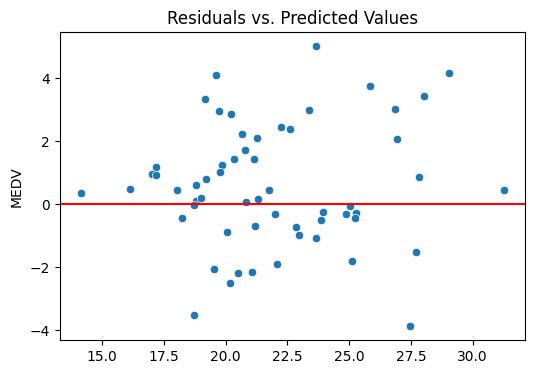

In [118]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red")
plt.title("Residuals vs. Predicted Values")
plt.show()

# 10. SHAP Explainability

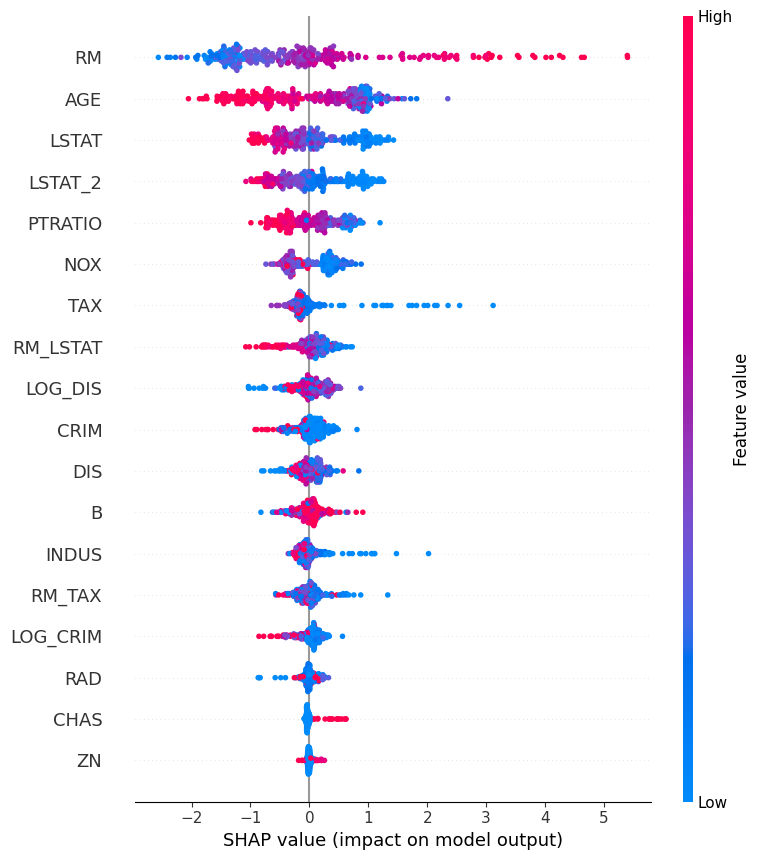

In [119]:
import shap
model = final_model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [120]:
joblib.dump(final_model, "../models/final_model.joblib")
print("Model saved successfully.")

Model saved successfully.


# Conclusion

### Final Results
- Best Model: CatBoostRegressor
- MSE: 4.042439876752244
- R2: 0.7615178842651105

### Key Features
- The model relies on:
- CRIM
- LSTAT
- RM
- DIS
- CHAS
- NOX
- INDUS
- AGE
- RAD
- TAX
- PTRATIO
- B
- ZN

### Next Steps
- Deploy the model
- Try more feature engineering
- Try more models
- Build prediction intervals